# Solution for Homework 2

In [2]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

# To plot pretty figures, use matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Below are functions that we "borrow" from the notebook usd in class 

### Copy functions from Class Notebook

In [3]:
from scipy import special

def Q(x):
    """Gaussian error integral"""
    return 0.5 - 0.5*special.erf(x/np.sqrt(2))

In [4]:
def pulse_shape(symbols, pulse, fsT):
    """Generate a pulse-shaped QAM signal
    
    Inputs:
    symbols - a sequence of information symbols; rate 1/T
    pulse - sampled pulse shape; rate fsT/T
    fsT - samples per symbol period

    Returns:
    Numpy array with fsT*(len(symbols) - 1) + len(pulse)  samples
    """
    # step 1: upsample the symbol sequence
    up_symbols = np.zeros(fsT * (len(symbols) - 1) + 1, dtype=symbols.dtype)
    up_symbols[::fsT] = symbols

    # step 2: filter
    return np.convolve(up_symbols, pulse)

In [5]:
def random_symbols(A, N):
    """generate random symbols from the constallation A
    
    Inputs:
    A - np.ndarray of symbols in constellation, e.g., A = np.array([1, -1]) for BPSK
    N - number of random symbols to produce

    Returns:
    Numpy array of length N
    """
    return A[np.random.randint(len(A), size=N)]

In [6]:
def MPE_decision_rule(Z, A):
    """Decide which symbol was most likely transmitted
    
    This function examines matched filter outputs (in vector Z) and for each element of Z selects the symbol 
    from constellation A that is closest.

    Inputs:
    Z - Vector of matched filter outputs
    A - Constellation

    Returns:
    Numpy array of the same length as Z
    """
    dec = np.empty_like(Z)

    for n in range(len(Z)):
        this_Z = Z[n]
        ind = np.argmin(np.abs(A-this_Z))
        dec[n] = A[ind]

    return dec

In [7]:
def half_sine_pulse(fsT):
    """Generate a pulse that is shaped like a half cycle of a sinusoid
    
    Inputs:
    fsT - number of samples per symbol period

    Returns:
    Numpy array with fsT+1 samples (the sample at time t=T is included)
    """

    tt = np.arange(fsT+1) / fsT
    return np.sqrt(2/fsT) * np.sin(np.pi*tt)


## Solution for Problem 2

**Problem Statement:** The
notebook from class 2 concluded with an example that showed how
to perform a Monte Carlo Simulation to estimate the symbol error
rate for a single SNR value. Since this is a symbol error
simulation, define SNR to be the ratio of symbol energy $E_s$ to
noise power spectral density $N_0$. 

1. Expand this simulation to cover the range of SNR values from 5dB to 15dB (in 1dB steps).
2. Compute the exact symbol error probability for the QPSK signal set over this range of SNRs.
3. Plot both the exact and the simulated error rate; use a logarithmic scale for the error probability and indicate 95% confidence intervals on the plot for the simulated error rate.

In [19]:
# Simulation Parameters
fsT = 8
pp = half_sine_pulse(fsT)   # this is normalized to unit energy
SNR_dB = np.arange(5., 16.)   # range of dB values

A = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2) # define a normalized QPSK constellation
N = 1024                    # number of symbols per burst

# simulation parameters
max_bursts = 1000
max_errors = 400

## storage for results
num_errors = np.zeros_like(SNR_dB, dtype=int)
num_symbols = np.zeros_like(num_errors)

P_exact = np.zeros_like(SNR_dB)
P_MC = np.zeros_like(SNR_dB)
sc = np.zeros_like(P_MC)

In [28]:
## the Monte Carlo loop; first over SNR
for n in range(len(SNR_dB)):
    N_bursts = 0
    N_errors = 0
    SNR = 10**(SNR_dB[n]/10)

    # then repeat until we have enough errors
    while N_bursts < max_bursts and N_errors < max_errors:
        # Transmitter
        sym = random_symbols(A, N)
        ss = pulse_shape(sym, pp, fsT)
    
        # Channel
        rr = ss + np.sqrt(0.5 * 1/SNR) * (np.random.randn(len(ss)) + 1j*np.random.randn(len(ss)))
    
        # receiver
        mf_out = np.convolve(rr, np.flip(pp))
        Z = mf_out[fsT:-fsT:fsT]
        dec = MPE_decision_rule(Z, A)

        # update simulation statistics
        N_bursts += 1
        N_errors += np.sum(np.not_equal(dec, sym))

    # done with this SNR; store results for this SNR
    num_errors[n] = N_errors
    num_symbols[n] = N*N_bursts
    P_MC[n] = num_errors[n]/num_symbols[n]
    sc[n] = 1.96 * np.sqrt(P_MC[n] * (1 - P_MC[n]) / num_symbols[n])
    P_exact[n] = 2*Q(np.sqrt(SNR)) - Q(np.sqrt(SNR))**2

    # show results for this SNR
    # print("SNR = {:4.1f} dB".format(SNR_dB[n]))
    # print("Found {:d} errors in {:d} symbols; estimated symbol error rate {:8.6f}".format(num_errors[n], num_symbols[n], P_MC[n]))
    # print("The exact value for the symbol error rate is: {:8.6f}".format(P_exact[n]))

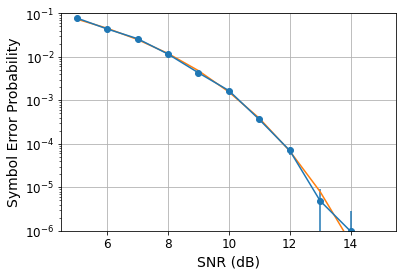

In [29]:
plt.errorbar(SNR_dB, P_MC, yerr=sc, fmt='-o', label="Monte Carlo")
plt.plot(SNR_dB, P_exact, label='Exact')

plt.grid()
plt.xlabel('SNR (dB)')
plt.ylabel('Symbol Error Probability')
plt.yscale('log')
plt.ylim([1e-6, 1e-1])

plt.show()